# Import

In [5]:
import sqlite3
from pathlib import Path
import os
import sys

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create database

In [11]:
db_path = Path('../DataBase/paysim.db')
if db_path.exists():
    print('Database already exists')

Database already exists


In [ ]:
# Relative paths from notebooks/ directory
db_path = Path('../DataBase/paysim.db')
csv_path = Path('../data/raw/paysimDataset.csv')

if db_path.exists():
    print('Database already exists')
else:
    print('Creating database..')
    db_path.parent.mkdir(parents=True, exist_ok=True)
    
    with sqlite3.connect(db_path) as conn:
        pd.read_csv(csv_path).to_sql(
            name='paysim',
            con=conn,
            index=False
        )
    print('Database created')


Database already exists


# Data Exploration

In [13]:
def return_query(query: str) -> pd.DataFrame:
    with sqlite3.connect(db_path) as conn:
        return pd.read_sql_query(
            query, 
            conn
        )

## Main dataframe

In [15]:
main_df = return_query('SELECT * FROM paysim')

In [16]:
main_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [22]:
main_df[main_df['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [27]:
main_df[(main_df['amount'] >= 200_000) & (main_df['isFraud'] == 1)]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.0,C116289363,0.00,0.00,1,0
2302,1,CASH_OUT,235238.66,C1499825229,235238.66,0.0,C2100440237,0.00,235238.66,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


## Basic dataframe metrics

In [ ]:
df_metrics = return_query(
    'SELECT ' \
    'COUNT(*) AS count, ' \
    'ROUND(MIN(amount), 2) AS min_amount, ' \
    'ROUND(MAX(amount), 2) AS max_amount, ' \
    'ROUND(AVG(amount), 2) AS avg_amount, ' \
    'ROUND(SUM(amount), 2) AS sum_amount, ' \
    'MIN(step) AS min_date, ' \
    'MAX(step) AS max_date, ' \
    'SUM(isFraud) AS fraud_count, '\
    'ROUND(SUM(CASE WHEN isFraud = 1 THEN amount ELSE 0 END), 2) AS fraud_amount ' \
    'FROM paysim'
)

In [ ]:
df_metrics

,metric,value
0,count,6.362620e+06
1,min_amount,0.000000e+00
2,max_amount,9.244552e+07
3,avg_amount,1.798619e+05
4,sum_amount,1.144393e+12
5,min_date,1.000000e+00
6,max_date,7.430000e+02
7,fraud_count,8.213000e+03
8,fraud_amount,1.205642e+10


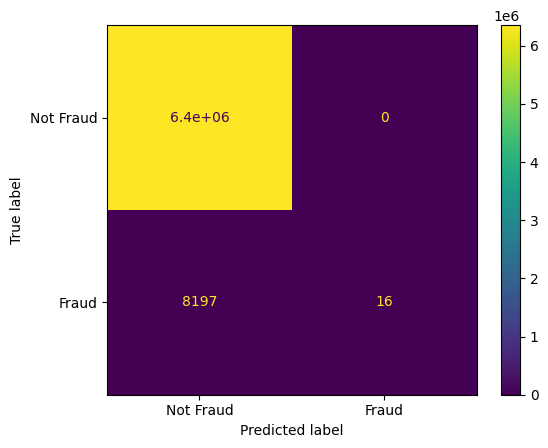

In [10]:
ConfusionMatrixDisplay(
    confusion_matrix(main_df['isFraud'], main_df['isFlaggedFraud']), display_labels=['Not Fraud', 'Fraud']
).plot()

## Transaction type analysis

In [ ]:
df_transaction_types = return_query(
    '''
    SELECT
    type,
    COUNT(*) AS count,
    ROUND(MIN(amount), 2) AS min_amount,
    ROUND(MAX(amount), 2) AS max_amount,
    ROUND(AVG(amount), 2) AS avg_amount,
    ROUND(SUM(amount), 2) AS sum_amount,
    SUM(isFraud) AS fraud_count,
    SUM(isFlaggedFraud) AS flagged_fraud_count
    FROM paysim
    GROUP BY type
    ORDER BY count DESC
    '''
)

In [ ]:
df_transaction_types['Fraud_percentage'] = round(df_transaction_types['fraud_count'] / df_transaction_types['count'] * 100,2)
df_transaction_types

## Origin analysis

In [ ]:
df_origin_clients = return_query(
    '''
    SELECT 
    nameOrig, 
    COUNT(*) AS count, 
    MIN(amount) AS min_amount, 
    MAX(amount) AS max_amount, 
    AVG(amount) AS avg_amount, 
    SUM(amount) AS sum_amount,
    SUM(isFraud) AS fraud_count,
    SUM(isFlaggedFraud) AS flagged_fraud_count
    FROM paysim
    GROUP BY nameOrig
    ORDER BY count DESC
    '''
)

In [12]:
df_origin_clients.sort_values(by='fraud_count', ascending=False).head(10)

,nameOrig,count,min_amount,max_amount,avg_amount,sum_amount,fraud_count,flagged_fraud_count
1463321,C557416000,1,700523.69,700523.69,700523.69,700523.69,1,0
125677,C964428747,1,167907.12,167907.12,167907.12,167907.12,1,0
2514849,C236875489,1,65488.05,65488.05,65488.05,65488.05,1,0
2066533,C373547831,1,2060748.45,2060748.45,2060748.45,2060748.45,1,0
1276380,C614130152,1,234723.40,234723.40,234723.40,234723.40,1,0
1122197,C661074170,1,14279.89,14279.89,14279.89,14279.89,1,0
2236083,C321662798,1,865948.49,865948.49,865948.49,865948.49,1,0
2115734,C358552175,1,11424.36,11424.36,11424.36,11424.36,1,0
3063054,C2002728636,1,355909.21,355909.21,355909.21,355909.21,1,0
660602,C801354252,1,378688.65,378688.65,378688.65,378688.65,1,0


## Destination Analysis

In [ ]:
df_destiny_clients = return_query(
    '''
    SELECT 
    nameDest, 
    COUNT(*) AS count, 
    MIN(amount) AS min_amount, 
    MAX(amount) AS max_amount, 
    AVG(amount) AS avg_amount, 
    SUM(amount) AS sum_amount,
    SUM(isFraud) AS fraud_count,
    SUM(isFlaggedFraud) AS flagged_fraud_count
    FROM paysim
    GROUP BY nameDest
    ORDER BY count DESC
    '''
)

In [ ]:
df_destiny_clients.sort_values(by='fraud_count', ascending=False).head(10)

In [ ]:
df_suspected_paysim = return_query(
    '''
    SELECT DISTINCT T.* 
    FROM paysim T
    WHERE T.nameDest IN (SELECT nameDest FROM paysim WHERE isFraud=1)
        OR T.nameOrig IN (SELECT nameOrig FROM paysim WHERE isFraud=1)
        OR T.nameDest IN (SELECT nameOrig FROM paysim WHERE isFraud=1)  
        OR T.nameOrig IN (SELECT nameDest FROM paysim WHERE isFraud=1)
    ''', 
)

In [ ]:
df_suspected_paysim

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
3,1,CASH_OUT,55105.90,C2007486296,0.00,0.0,C932583850,317952.89,2719172.89,0,0
4,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
65689,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
65690,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
65691,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
65692,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
